In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


/Users/harshitgupta/Desktop/vs /VS-Data-Den/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = pd.read_parquet('/Users/harshitgupta/Desktop/vs /VS-Data-Den/data_cleaning/sales_historic_1.parquet')

In [3]:
df = pd.read_csv('model_dataset.csv')

In [4]:
data.columns

Index(['STORELNK', 'ARTICLE', 'DATE_FIELD', 'SALES', 'UNITS', 'DATEMODIFIED',
       'WEEK', 'FY', 'YEARWEEK', 'UPLOAD_DATE', 'SALESLOCALCURRENCY', 'SEASON',
       'QUARTERNUMBER', 'MONTHLNK', 'REPORTSALES', 'UNITSF', 'STOREID',
       'EOWSTOREINV', 'HISTORICALSALESID', 'MODIFIED_DATE',
       'SALES_COST_AMT_USD', 'LBI_COGS_AUC_USD', 'NEW_SKU_x', 'EAN',
       'CHOICE_ID', 'CHOICE_DESC', 'STYLE_ID', 'STYLE_DESC', 'SUBCLASS_ID',
       'SUBCLASS_DESC', 'CLASS_ID', 'CLASS_DESC', 'CATEGORY_ID',
       'CATEGORY_DESC', 'SECTOR_ID', 'SECTOR_DESC', 'ENTERPRISE_ID',
       'ENTERPRISE_DESC', 'SUBBRAND_ID', 'SUBBRAND_DESC', 'VARIANT_STATUS',
       'SECTOR_SUBBRAND', 'SECTOR_SUBBRAND_DESC', 'CATEGORY_SUBBRAND',
       'CATEGORY_SUBBRAND_DESC', 'CLASS_SUBBRAND', 'CLASS_SUBBRAND_DESC',
       'SUBCLASS_SUBBRAND', 'SUBCLASS_SUBBRAND_DESC', 'PRICE_TIER',
       'Unnamed: 28', 'PROD_LIFECYCLE', 'COLLECTION', 'MATERIAL_TYPE',
       'NEW_SKU_y'],
      dtype='object')

In [5]:
df.dtypes

PTNR_REGIONAL_MASTER_CD    float64
YEARWEEK                    object
TOTAL_SALES                float64
dtype: object

In [6]:
data['DATE_FIELD'] = pd.to_datetime(data['DATE_FIELD'])
data['YEARWEEK'] = data['DATE_FIELD'].dt.strftime('%Y-%U')

In [7]:
features = ['SALES','UNITS'] 


In [8]:
agg_data = data.groupby(['CHOICE_ID', 'YEARWEEK']).agg({
    'SALES': 'sum',
    'UNITS': 'sum'
}).reset_index()


In [9]:
train_data, test_data = train_test_split(agg_data, test_size=0.2, shuffle=False)


In [26]:
train_data.head(10)

,CHOICE_ID,YEARWEEK,SALES,UNITS
0,100190000000,2018-00,213.05,3.0
1,100190000000,2018-01,71.23,1.0
2,100190000000,2018-02,89.47,1.0
3,100190000000,2018-03,1159.22,18.0
4,100190000000,2018-05,160.53,2.0
5,100190000000,2018-06,481.56,8.0
6,100190000000,2018-08,90.83,1.0
7,100190000000,2018-10,120.72,2.0
8,100190000000,2018-11,824.17,11.0
9,100190000000,2018-12,190.11,4.0


In [10]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])

In [28]:
train_scaled


array([[0.00126952, 0.0017452 ],
       [0.00055313, 0.00142789],
       [0.00064527, 0.00142789],
       ...,
       [0.00020645, 0.00142789],
       [0.00020256, 0.00142789],
       [0.00020054, 0.00142789]])

In [11]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

In [12]:
sequence_length = 10  #
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [27]:
print(X_train)

[[[0.00126952 0.0017452 ]
  [0.00055313 0.00142789]
  [0.00064527 0.00142789]
  ...
  [0.00080312 0.00158655]
  [0.00435653 0.00301444]
  [0.00115364 0.00190386]]

 [[0.00055313 0.00142789]
  [0.00064527 0.00142789]
  [0.00604901 0.00412502]
  ...
  [0.00435653 0.00301444]
  [0.00115364 0.00190386]
  [0.00475671 0.00380771]]

 [[0.00064527 0.00142789]
  [0.00604901 0.00412502]
  [0.00100422 0.00158655]
  ...
  [0.00115364 0.00190386]
  [0.00475671 0.00380771]
  [0.0003244  0.00142789]]

 ...

 [[0.00025004 0.00158655]
  [0.00026803 0.0017452 ]
  [0.00021125 0.00142789]
  ...
  [0.00022327 0.00206251]
  [0.00020963 0.00142789]
  [0.00023898 0.00158655]]

 [[0.00026803 0.0017452 ]
  [0.00021125 0.00142789]
  [0.0002165  0.00142789]
  ...
  [0.00020963 0.00142789]
  [0.00023898 0.00158655]
  [0.00020645 0.00142789]]

 [[0.00021125 0.00142789]
  [0.0002165  0.00142789]
  [0.00020438 0.00142789]
  ...
  [0.00023898 0.00158655]
  [0.00020645 0.00142789]
  [0.00020256 0.00142789]]]


In [13]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(2)  
])

2024-04-18 11:22:47.816747: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-18 11:22:47.818987: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-18 11:22:47.819007: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-18 11:22:47.819070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 11:22:47.819424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/harshitgupta/Desktop/vs /VS-Data-Den/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. W

In [14]:
model.compile(optimizer='adam', loss='mse')


In [15]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20


2024-04-18 11:22:48.722662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0061 - val_loss: 1.2152e-05
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - val_loss: 5.9483e-05
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - val_loss: 2.8730e-05
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0049 - val_loss: 8.7549e-05
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034 - val_loss: 7.9065e-05
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 1.9500e-05
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0032 - val_loss: 3.0368e-05
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0035 - val_loss: 3.5419e-05
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046 - val_loss: 2.9542e-05
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 1.2202e-05
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028 - val_loss: 9.5910e-05
Epoch 12/20
60/60 ━━━━━━━━━━━━

In [16]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6966e-04
Test Loss: 0.0005444387788884342


In [17]:
agg_data_filtered = agg_data[agg_data['SALES'] >= 1]


In [18]:
def predict_demand(trend_start, trend_end):
    trend_data = agg_data[(agg_data['YEARWEEK'] >= trend_start) & (agg_data['YEARWEEK'] <= trend_end)]
    scaled_trend_data = scaler.transform(trend_data[features])
    X_trend, _ = create_sequences(scaled_trend_data, sequence_length)
    predictions = model.predict(X_trend)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [19]:
trend_start = '2024-01-01'
trend_end = '2024-12-31'  
predictions = predict_demand(trend_start, trend_end)
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
[[-499.9974      16.179836 ]
 [-522.30383     15.625603 ]
 [-554.6562      14.84457  ]
 [-572.1456      14.4076395]
 [-599.7797      13.792891 ]
 [-627.31525     13.207533 ]
 [-648.66705     12.642433 ]
 [-646.9472      12.473034 ]
 [-650.1125      12.426548 ]
 [-652.1162      12.417109 ]
 [-655.57904     12.374715 ]
 [-662.66174     12.320017 ]
 [-666.8657      12.3042965]
 [-669.1154      12.411268 ]
 [-670.3116      12.42164  ]]


In [20]:
import matplotlib.pyplot as plt


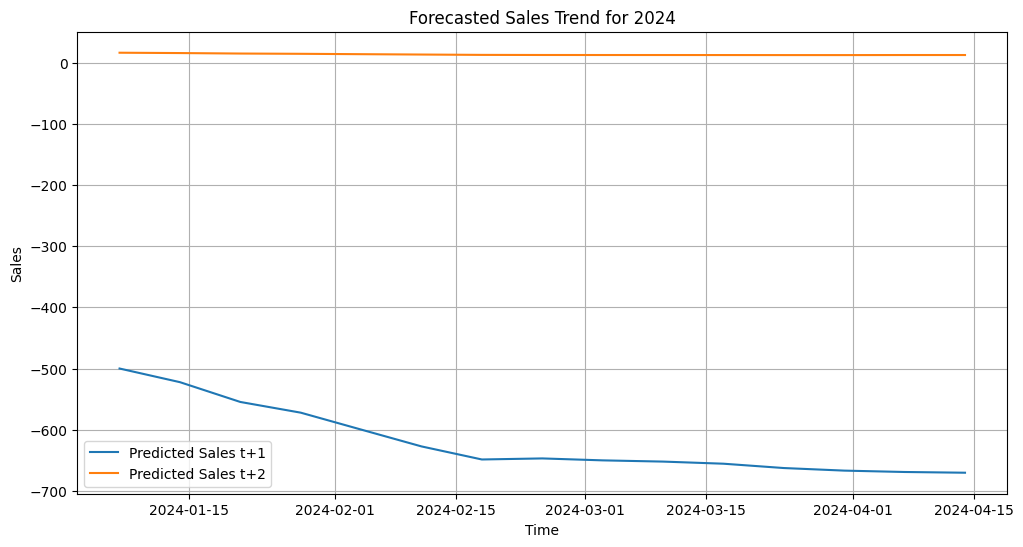

In [21]:
predictions_df = pd.DataFrame(predictions, columns=['Predicted Sales t+1', 'Predicted Sales t+2'])

# Generate a range of dates corresponding to the prediction periods
date_range = pd.date_range(start=trend_start, periods=len(predictions), freq='W')

# Plot the predicted sales against time
plt.figure(figsize=(12, 6))
plt.plot(date_range, predictions_df['Predicted Sales t+1'], label='Predicted Sales t+1')
plt.plot(date_range, predictions_df['Predicted Sales t+2'], label='Predicted Sales t+2')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Forecasted Sales Trend for 2024')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error

In [ ]:
np.sqrt(mean_squared_error(test['SALES'],prediction))

In [31]:
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Squared Error: 2844130.1262689135
